In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
base_dir = Path.home() / "Desktop" / "rbi-lite"
params_path = base_dir / "data" / "params.json"
fig_dir = base_dir / "figures"
data_dir = base_dir / "data"
fig_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

with open(params_path, "r", encoding="utf-8") as f:
    params = json.load(f)

t0 = float(params["t0_mm"])
t_min = float(params["t_min_mm"])
r_mean = float(params["r_mean_mm_per_year"])
r_std = float(params["r_std_mm_per_year"])
meas_std_default = float(params["meas_std_mm"])
horizon_years = int(params["horizon_years"])
n_mc = int(params.get("n_mc", 20000))

print("Loaded:", params_path)
print("t0,t_min:", t0, t_min)
print("prior r_mean,r_std:", r_mean, r_std)
print("meas_std_default:", meas_std_default)
print("horizon_years:", horizon_years, "n_mc:", n_mc)

Loaded: C:\Users\LENOVO\Desktop\rbi-lite\data\params.json
t0,t_min: 12.0 7.0
prior r_mean,r_std: 0.8 0.25
meas_std_default: 0.2
horizon_years: 10 n_mc: 20000


In [3]:
# Opsi interval inspeksi yang boleh dipilih policy
interval_months = np.array([3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 77, 80])
interval_years = interval_months / 12

# Biaya
C_inspect = 5_000_000
C_fail = 500_000_000

# Batas risiko (dipakai memilih interval)
risk_limit = 0.01

# POD model (sederhana tapi berguna)
t_detect = t_min + 0.5
POD_high = 0.85
POD_low = 0.05

print("Intervals (months):", interval_months)
print("risk_limit:", risk_limit)
print("t_detect:", t_detect, "POD_high:", POD_high, "POD_low:", POD_low)

Intervals (months): [ 3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69 72
 75 77 80]
risk_limit: 0.01
t_detect: 7.5 POD_high: 0.85 POD_low: 0.05


In [4]:
rng = np.random.default_rng(123)

# laju korosi sebenarnya (truth), tidak diketahui engineer
r_true = rng.normal(loc=r_mean, scale=r_std)
r_true = max(0.0, float(r_true))

def thickness_true(time_years: float) -> float:
    return t0 - r_true * time_years

print("r_true (mm/year) =", r_true)
print("true thickness at t=0:", thickness_true(0.0))
print("true thickness at t=horizon:", thickness_true(horizon_years))

r_true (mm/year) = 0.5527196624130373
true thickness at t=0: 12.0
true thickness at t=horizon: 6.472803375869628


In [5]:
def init_r_grid(r_mean, r_std, n_grid=2000):
    r_max = max(2.0, r_mean + 6*r_std)
    r_grid = np.linspace(0.0, r_max, n_grid)
    prior_pdf = norm.pdf(r_grid, loc=r_mean, scale=r_std)
    prior_pdf = prior_pdf / np.trapezoid(prior_pdf, r_grid)
    return r_grid, prior_pdf

r_grid, posterior_pdf = init_r_grid(r_mean, r_std, n_grid=2000)
np.trapezoid(posterior_pdf, r_grid)

np.float64(1.0)

In [6]:
def update_posterior_with_inspection(
    r_grid: np.ndarray,
    prior_pdf: np.ndarray,
    t0: float,
    t_obs_time: float,
    thickness_measured: float,
    meas_std: float
) -> np.ndarray:
    """
    posterior ∝ prior * likelihood(thickness_measured | r)
    thickness_pred = t0 - r * time
    measurement noise ~ Normal(0, meas_std)
    """
    # prediksi ketebalan untuk semua r
    t_pred = t0 - r_grid * t_obs_time

    # log posterior unnormalized
    log_prior = np.log(prior_pdf + 1e-300)
    log_like = norm.logpdf(thickness_measured, loc=t_pred, scale=meas_std)
    log_post = log_prior + log_like

    # stabilisasi
    log_post -= np.max(log_post)

    post_unnorm = np.exp(log_post)
    post_pdf = post_unnorm / np.trapezoid(post_unnorm, r_grid)
    return post_pdf

In [7]:
def choose_next_interval(
    interval_months: np.ndarray,
    interval_years: np.ndarray,
    r_grid: np.ndarray,
    posterior_pdf: np.ndarray,
    th_meas_last: float,
    meas_std_last: float,
    t0: float,
    t_min: float,
    t_detect: float,
    POD_high: float,
    POD_low: float,
    risk_limit: float,
    C_inspect: float,
    C_fail: float,
    n_mc: int,
    rng: np.random.Generator
):
    # sample r dari posterior grid
    p_grid = posterior_pdf / posterior_pdf.sum()
    idx = rng.choice(len(r_grid), size=n_mc, replace=True, p=p_grid)
    r_samples = r_grid[idx]
    r_safe = np.clip(r_samples, 1e-9, None)

    # sample thickness "now" dari measurement terakhir (uncertainty)
    th_now = rng.normal(loc=th_meas_last, scale=meas_std_last, size=n_mc)
    th_now = np.clip(th_now, 0.0, t0)

    # TTF dan TTD
    ttf = np.where(th_now <= t_min, 0.0, (th_now - t_min) / r_safe)
    ttd = np.where(th_now <= t_detect, 0.0, (th_now - t_detect) / r_safe)

    rows = []
    for m, d in zip(interval_months, interval_years):
        fail_before_next = (ttf <= d)
        enters_detect_zone = (ttd <= d)
        pod = np.where(enters_detect_zone, POD_high, POD_low)
        detected = (rng.random(size=n_mc) < pod)
        missed_fail = fail_before_next & (~detected)

        p_fail = fail_before_next.mean()
        p_missed = missed_fail.mean()
        exp_cost = C_inspect + p_missed * C_fail

        rows.append({
            "interval_months": int(m),
            "interval_years": float(d),
            "p_fail": p_fail,
            "p_missed_fail": p_missed,
            "expected_cost": exp_cost,
            "meets_risk_limit": bool(p_fail <= risk_limit)
        })

    df = pd.DataFrame(rows)

    feasible = df[df["meets_risk_limit"]]
    if len(feasible) == 0:
        # fallback: pilih interval paling pendek
        choice = df.sort_values("interval_months").iloc[0]
        choice_reason = "fallback_shortest_no_feasible"
    else:
        choice = feasible.loc[feasible["expected_cost"].idxmin()]
        choice_reason = "min_cost_under_risk_limit"

    return choice, df

In [8]:
# State awal simulasi
t_current = 0.0

# Mulai dengan "inspeksi awal" di t=0 (anggap ada measurement baseline)
# Di dunia nyata ini commissioning/initial thickness check.
th_true_current = thickness_true(t_current)
th_meas_current = float(rng.normal(loc=th_true_current, scale=meas_std_default))
th_meas_current = float(np.clip(th_meas_current, 0.0, t0))
meas_std_current = meas_std_default

# Posterior mulai dari prior
r_grid, posterior_pdf = init_r_grid(r_mean, r_std, n_grid=2000)

# Log jadwal
events = []
total_cost = 0.0
failed = False
fail_time = None

# Simpan event awal (t=0)
events.append({
    "event": "inspection",
    "time_years": t_current,
    "true_thickness_mm": th_true_current,
    "measured_thickness_mm": th_meas_current,
    "meas_std_mm": meas_std_current,
    "posterior_mean_r": float(np.trapezoid(r_grid * posterior_pdf, r_grid)),
    "interval_chosen_months": None,
    "reason": "initial",
    "detected_hazard": None,
    "failure_occurred_before_inspection": None,
    "missed_detection": None,
    "cost_added": 0.0,
    "total_cost": total_cost
})

# Update posterior dengan inspeksi awal (opsional; untuk konsistensi)
posterior_pdf = update_posterior_with_inspection(
    r_grid, posterior_pdf, t0, t_current, th_meas_current, meas_std_current
)

# Simulasi berulang
max_cycles = 50
for cycle in range(max_cycles):
    # 1) pilih interval berikutnya berdasarkan belief saat ini
    choice, debug_table = choose_next_interval(
        interval_months, interval_years,
        r_grid, posterior_pdf,
        th_meas_current, meas_std_current,
        t0, t_min,
        t_detect, POD_high, POD_low,
        risk_limit,
        C_inspect, C_fail,
        n_mc, rng
    )

    delta = float(choice["interval_years"])
    interval_m = int(choice["interval_months"])
    reason = str(choice.get("reason", "unknown"))


    t_next = t_current + delta
    if t_next > horizon_years:
        # stop di horizon (tidak jadikan inspeksi di luar horizon)
        break

    # 2) Truth evolves sampai t_next; cek apakah failure terjadi sebelum t_next
    # failure time dari truth: solve t0 - r_true*t = t_min => t = (t0 - t_min)/r_true
    if r_true > 0:
        t_fail_absolute = (t0 - t_min) / r_true
    else:
        t_fail_absolute = np.inf

    failure_before_next = (t_fail_absolute <= t_next)
    failure_in_interval = (t_fail_absolute > t_current) and (t_fail_absolute <= t_next)

    # 3) MODEL POD untuk interval ini (berbasis truth)
    # kapan truth masuk zona detect?
    if r_true > 0:
        t_enter_detect = (t0 - t_detect) / r_true
    else:
        t_enter_detect = np.inf

    enters_detect_zone = (t_enter_detect <= t_next)

    # Prob deteksi pada inspeksi berikutnya
    pod = POD_high if enters_detect_zone else POD_low
    detected = bool(rng.random() < pod)

    missed_detection = bool(failure_before_next and (not detected))

    # 4) biaya inspeksi selalu dibayar jika benar-benar sampai inspeksi berikutnya
    total_cost += C_inspect
    cost_added = C_inspect

    # 5) kalau failure terjadi sebelum inspeksi dan missed detection, tambahkan failure cost & stop
    if failure_before_next and missed_detection:
        total_cost += C_fail
        cost_added += C_fail
        failed = True
        fail_time = float(t_fail_absolute)

    # 6) lakukan "inspeksi" di t_next: dapat measurement (jika belum gagal sebelum sampai inspeksi)
    # Kalau failure terjadi sebelum inspeksi, dalam dunia nyata inspeksi mungkin tidak terjadi (shutdown/emergency).
    # Untuk simulasi sederhana: jika failed==True, log event failure dan berhenti.
    if failed:
        events.append({
            "event": "failure",
            "time_years": fail_time,
            "true_thickness_mm": thickness_true(fail_time),
            "measured_thickness_mm": None,
            "meas_std_mm": None,
            "posterior_mean_r": float(np.trapezoid(r_grid * posterior_pdf, r_grid)),
            "interval_chosen_months": interval_m,
            "reason": reason,
            "detected_hazard": detected,
            "failure_occurred_before_inspection": True,
            "missed_detection": True,
            "cost_added": cost_added,
            "total_cost": total_cost
        })
        break

    # jika belum gagal, lakukan inspeksi di t_next
    t_current = t_next
    th_true_current = thickness_true(t_current)
    th_meas_current = float(rng.normal(loc=th_true_current, scale=meas_std_default))
    th_meas_current = float(np.clip(th_meas_current, 0.0, t0))
    meas_std_current = meas_std_default

    # log event inspeksi
    events.append({
        "event": "inspection",
        "time_years": t_current,
        "true_thickness_mm": th_true_current,
        "measured_thickness_mm": th_meas_current,
        "meas_std_mm": meas_std_current,
        "posterior_mean_r": float(np.trapezoid(r_grid * posterior_pdf, r_grid)),
        "interval_chosen_months": interval_m,
        "reason": reason,
        "detected_hazard": detected,
        "failure_occurred_before_inspection": bool(failure_in_interval),
        "missed_detection": bool(missed_detection),
        "cost_added": cost_added,
        "total_cost": total_cost
    })

    # 7) update posterior dengan measurement baru
    posterior_pdf = update_posterior_with_inspection(
        r_grid, posterior_pdf, t0, t_current, th_meas_current, meas_std_current
    )

# jadikan DataFrame
schedule = pd.DataFrame(events)
schedule

,event,time_years,true_thickness_mm,measured_thickness_mm,meas_std_mm,posterior_mean_r,interval_chosen_months,reason,detected_hazard,failure_occurred_before_inspection,missed_detection,cost_added,total_cost
0,inspection,0.00,12.000000,11.926443,0.2,0.800596,NaN,initial,None,None,None,0.0,0.0
1,inspection,0.25,11.861820,12.000000,0.2,0.800596,3.0,unknown,False,False,False,5000000.0,5000000.0
2,inspection,0.50,11.723640,11.609997,0.2,0.729724,3.0,unknown,False,False,False,5000000.0,10000000.0
3,inspection,0.75,11.585460,11.289878,0.2,0.742375,3.0,unknown,False,False,False,5000000.0,15000000.0
4,inspection,1.00,11.447280,11.632548,0.2,0.818213,3.0,unknown,False,False,False,5000000.0,20000000.0
5,inspection,1.25,11.309100,11.311436,0.2,0.638984,3.0,unknown,False,False,False,5000000.0,25000000.0
6,inspection,1.50,11.170921,11.216787,0.2,0.605211,3.0,unknown,False,False,False,5000000.0,30000000.0
7,inspection,1.75,11.032741,11.301373,0.2,0.575673,3.0,unknown,False,False,False,5000000.0,35000000.0
8,inspection,2.00,10.894561,10.849636,0.2,0.518122,3.0,unknown,True,False,False,5000000.0,40000000.0
9,inspection,2.25,10.756381,10.939955,0.2,0.535168,3.0,unknown,False,False,False,5000000.0,45000000.0


In [9]:
out_csv = data_dir / "step6_policy_schedule.csv"
schedule.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Saved: C:\Users\LENOVO\Desktop\rbi-lite\data\step6_policy_schedule.csv


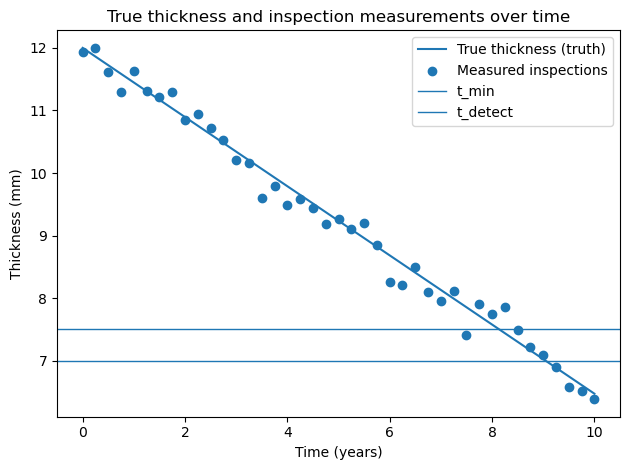

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step6_thickness_and_inspections.png


In [10]:
# garis ketebalan true
t_line = np.linspace(0, horizon_years, 300)
th_line = t0 - r_true * t_line

# titik inspeksi
insp_only = schedule[schedule["event"] == "inspection"].copy()

plt.figure()
plt.plot(t_line, th_line, label="True thickness (truth)")
plt.scatter(insp_only["time_years"], insp_only["measured_thickness_mm"], label="Measured inspections")
plt.axhline(t_min, linewidth=1, label="t_min")
plt.axhline(t_detect, linewidth=1, label="t_detect")
plt.xlabel("Time (years)")
plt.ylabel("Thickness (mm)")
plt.title("True thickness and inspection measurements over time")
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / "step6_thickness_and_inspections.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step6_thickness_and_inspections.png")

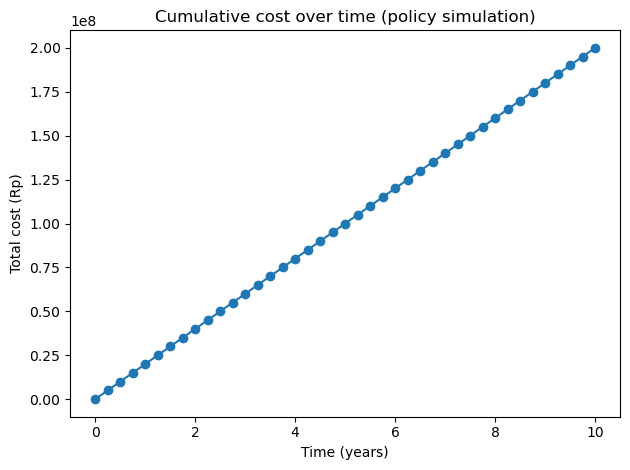

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step6_cost_over_time.png


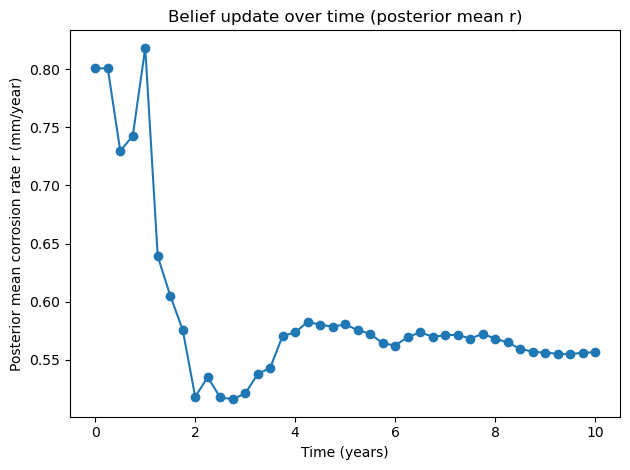

Saved: C:\Users\LENOVO\Desktop\rbi-lite\figures\step6_posterior_mean_r_over_time.png


In [11]:
#Plot biaya kumulatif dan indikator risiko
plt.figure()
plt.plot(schedule["time_years"], schedule["total_cost"], marker="o")
plt.xlabel("Time (years)")
plt.ylabel("Total cost (Rp)")
plt.title("Cumulative cost over time (policy simulation)")
plt.tight_layout()
plt.savefig(fig_dir / "step6_cost_over_time.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step6_cost_over_time.png")

plt.figure()
plt.plot(schedule["time_years"], schedule["posterior_mean_r"], marker="o")
plt.xlabel("Time (years)")
plt.ylabel("Posterior mean corrosion rate r (mm/year)")
plt.title("Belief update over time (posterior mean r)")
plt.tight_layout()
plt.savefig(fig_dir / "step6_posterior_mean_r_over_time.png", dpi=200)
plt.show()

print("Saved:", fig_dir / "step6_posterior_mean_r_over_time.png")

In [12]:
#ringkasan hasil
n_insp = (schedule["event"] == "inspection").sum()
n_fail = (schedule["event"] == "failure").sum()
missed = (
    schedule["missed_detection"]
    .astype("boolean")   # pandas nullable BooleanDtype
    .fillna(False)
    .sum()
)

print("==== SUMMARY ====")
print("r_true (unknown to engineer):", r_true)
print("Number of inspections:", int(n_insp))
print("Failure occurred?:", bool(n_fail > 0))
if n_fail > 0:
    ft = float(schedule[schedule["event"]=="failure"]["time_years"].iloc[0])
    print("Failure time (years):", ft)
print("Missed detections count:", int(missed))
print("Total cost (Rp):", f"{float(schedule['total_cost'].iloc[-1]):,.0f}")

==== SUMMARY ====
r_true (unknown to engineer): 0.5527196624130373
Number of inspections: 41
Failure occurred?: False
Missed detections count: 0
Total cost (Rp): 200,000,000
